# DFT calculated energies

#### Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import numpy as np
from ase.db import connect
import sys
import pandas as pd
from sklearn.model_selection import train_test_split;
import xgboost as xgb
from xgboost import XGBRegressor;
import time
from tqdm.notebook import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from collections import Counter

figure_folder = "../figures/DFT_calc_energies/"
DFT_folder = "../DFT_data/"
db_folder = "../DFT_data/"
# The COOH Pt data is in "single_element_COOH_C_adsorbed_out.db"
db_name_SE_COOH = "single_element_COOH_C_adsorbed_out.db"
# THe H data is in "single_element_H_out.db"
db_name_SE_H = "single_element_H_out.db"
db_name_SE = "single_element_slabs_out.db"

sys.path.append('../scripts')
from Slab import expand_triangle, Slab, inside_triangle
from FeatureReader import OntopStandard111, FccStandard111
from ase.db import connect
from ase.visualize import view

features_folder = "../csv_features/"

import sys
import os

# Define the path to the folder containing the functions.py file
path_to_functions = "../scripts/functions.py"

# Get the absolute path of the functions.py file
absolute_path = os.path.abspath(path_to_functions)

# Add the folder containing the functions.py file to the module search path
sys.path.append(os.path.dirname(absolute_path))

# Now you can import the learning_curve function from functions.py
from functions import learning_curve, single_parity_plot

#Load H binding energy prediction model
H_DFT_model = xgb.Booster({'nthread': 8})
H_DFT_model.load_model("../models/"+"H_DFT.model")

#Load COOH binding energy prediction model
COOH_DFT_model = xgb.Booster({'nthread': 8})
COOH_DFT_model.load_model("../models/"+"COOH_DFT.model")

models = {"H": H_DFT_model, "COOH": COOH_DFT_model}

# Specify metal colors
metal_colors = dict(Pt = '#babbcb',
                    #Ru = '#f4973a',
                    #Rh = '#1797d3',
                    #Ir = '#a5bc16',
                    #Re = '#901e64',
                    #Os = '#154c72',
                    Pd = '#1f8685',
                    Ag = '#c3cdd6',
                    Cu = '#B87333',
                    Au = '#fdd766')

/Users/marcusnorgaardweng/miniforge3/envs/PUK/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


#### Chan numbers

In [2]:
# Free (eV)
CO2   = {"ZPE": 0.31, "CpdT": 0.10, "minusTS": -0.66, "TS": 0.66}
CO    = {"ZPE": 0.13, "CpdT": 0.09, "minusTS": -0.61, "TS": 0.61}
H2    = {"ZPE": 0.28, "CpdT": 0.09, "minusTS": -0.40, "TS": 0.40}
H2O   = {"ZPE": 0.57, "CpdT": 0.10, "minusTS": -0.67, "TS": 0.67}
HCOOH = {"ZPE": 0.90, "CpdT": 0.11, "minusTS": -0.99, "TS": 0.99}
#Slab = {"ZPE": 0.00, "CpdT": 0.00, "minusTS": -0.00} #Holy moly, den her overskrev Slab funktionen

# *Bound to the surface (eV)
# Bidentate *OOCH?
bound_CO   = {"ZPE": 0.19, "CpdT": 0.08, "minusTS": -0.16, "TS": 0.16}
bound_OH   = {"ZPE": 0.36, "CpdT": 0.05, "minusTS": -0.08, "TS": 0.08}
bound_OCHO = {"ZPE": 0.62, "CpdT": 0.11, "minusTS": -0.24, "TS": 0.24} #Either bidentate or monodentate. Use for both for now
bound_O    = {"ZPE": 0.07, "CpdT": 0.03, "minusTS": -0.04, "TS": 0.04}
bound_COOH = {"ZPE": 0.62, "CpdT": 0.10, "minusTS": -0.19, "TS": 0.19}
bound_H    = {"ZPE": 0.23, "CpdT": 0.01, "minusTS": -0.01, "TS": 0.01}

# Approximation Factors (FA)
AF = {"CO2": CO2, "CO": CO, "H2": H2, "H2O": H2O, "HCOOH": HCOOH, \
      "bound_CO": bound_CO, "bound_OH": bound_OH, "bound_OCHO": bound_OCHO, \
      "bound_O": bound_O, "bound_COOH": bound_COOH, "bound_H": bound_H}

# This is from the molecules_out.db file
molecules_dict = {'CO': -12.848598765234707,\
 'CO2': -19.15168636258064,\
 'CH2O2': -25.7548327798152,\
 'C2H4O2': -41.95993780269195,\
 'H2': -6.67878491734772,\
 'H2O': -12.225511685485456,\
 'CH2O': -19.92286258910958,\
 'CH4O': -27.652189372849637,\
 'C2H6O': -43.67355392866396,\
 'C2H2O2': -32.92328015484662,\
 'C2H2O4': -44.117581976029946}

#### Plotting

#### Fetching DFT data

In [3]:
SE_COOH_metals = []
SE_COOH_energies = []

with connect(f'{DFT_folder}{db_name_SE_COOH}') as db_COOH:
    for row_slab in db_COOH.select('energy'):
        SE_COOH_energies.append(row_slab.energy)
        SE_COOH_metals.append(row_slab.formula[0:2])

SE_H_metals = []
SE_H_energies = []

with connect(f'{DFT_folder}{db_name_SE_H}') as db_H:
    for row_slab in db_H.select('energy'):
        SE_H_energies.append(row_slab.energy)
        SE_H_metals.append(row_slab.formula[0:2])
           
SE_slab_metals = []
SE_slab_energies = []

with connect(f'{DFT_folder}{db_name_SE}') as db_slab:
    for row_slab in db_slab.select('energy'):
        SE_slab_energies.append(row_slab.energy)
        SE_slab_metals.append(row_slab.formula[0:2])

#### Subtracting the slabs

In [18]:
DeltaE_COOH = np.array(SE_COOH_energies) - np.array(SE_slab_energies) - molecules_dict["CO2"] - 1/2*molecules_dict["H2"]
DeltaE_H = np.array(SE_H_energies) - np.array(SE_slab_energies) - 1/2*molecules_dict["H2"]

#### Plotting energies from single elements

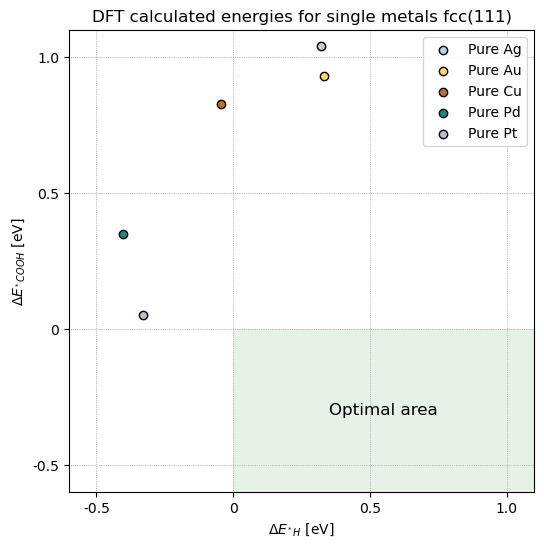

In [7]:
# Create a figure and axes
fig, ax = plt.subplots(figsize = (6, 6))

# Set the limits for both x and y axes
ax.set_xlim(-0.6, 1.1)
ax.set_ylim(-0.6, 1.1)

## Set the major ticks and tick labels
#ax.set_xticks([-0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0])
#ax.set_xticklabels([-0.5, '', 0, '', 0.5, '', 1.0])
#ax.set_yticks([-0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0])
#ax.set_yticklabels([-0.5, '', 0, '', 0.5, '', 1.0])

# Set the major ticks and tick labels
ax.set_xticks([-0.5, 0, 0.5, 1.0])
ax.set_xticklabels([-0.5, 0, 0.5, 1.0])
ax.set_yticks([-0.5, 0, 0.5, 1.0])
ax.set_yticklabels([-0.5, 0, 0.5, 1.0])

# Set the grid lines
ax.grid(which='both', linestyle=':', linewidth=0.5, color='gray')

ax.set_title("DFT calculated energies for single metals fcc(111)")
ax.set_xlabel("$\Delta E_{^*H}$ [eV]")
ax.set_ylabel("$\Delta E_{^*COOH}$ [eV]")

for i, metal in enumerate(SE_slab_metals):
        ax.scatter(DeltaE_H[i], DeltaE_COOH[i], label = "Pure "+metal, marker = "o", c = metal_colors[metal], edgecolors='black')
    
if True:
    # Create a rectangle patch
    rect = patches.Rectangle((0, 0), 1.1, -0.6, linewidth=1, edgecolor='none', facecolor='green', alpha = 0.1)

    # Add the rectangle to the plot
    ax.add_patch(rect)
    
    label_text = f'Optimal area' #This can show how many points are in there as well
    label_x = 0.55
    label_y = -0.3
    ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=12)

ax.legend()
plt.savefig("../figures/DFT_calc_energies/"+"Single_Metals"+".png", dpi = 600, bbox_inches = "tight")
plt.show()

### Plotting predicted energies from custom surface

In [82]:
# Maybe I should have a smart kind of plot, where, when you hover over it, it shows the xy coordinates and you can go check what it looks like. I even have a function from the swimming ring thing that can plot nice circles from a 2by2 surface
metals = ['Ag', 'Au', 'Cu', 'Pd', 'Pt']
## This routine includes: 

# Initialize a surface from a given stochiometry
dim_x, dim_y, split = 100, 100, [0.2 , 0.2 , 0.2 , 0.2 , 0.2 ]

# 140by140 100 its - corner
#best_stochiometry = [0.8458380615695716, 1.0, 0.0, 0.5242110298660663, 0.689633397655569]
#dim_x, dim_y, split = 140, 140, best_stochiometry

# 140by140 100 its - diagonal
#best_stochiometry = [1.0, 1.0, 0.0, 0.0, 0.6098243992113722]
#dim_x, dim_y, split = 140, 140, best_stochiometry

# 140by140 10 its - left corner
dim_x, dim_y, split = 100, 100, [0.05641157902710027, 0.7219987722668249, 0.9385527090157504, 0.0007787658410143285, 0.9922115592912177]

# 140by140 10 its - both corners
dim_x, dim_y, split = 100, 100, [0.05641157902710027, 0.7219987722668249, 0.9385527090157504, 0.0007787658410143285, 0.9922115592912177]

# Swim rings
dim_x, dim_y, split = 100, 100, [0, 6, 0, 0, 1]

stochiometry = dict(zip(metals, np.array(split)/np.sum(split)))
surface = initialize_surface(dim_x, dim_y, metals, split)

# Predict energies on all sites for both adsorbates
surface = precompute_binding_energies_TQDM(surface, dim_x, dim_y, models, predict_G)

Predicting all ΔG:   0%|          | 0/10000 [00:00<?, ?it/s]

#### Sort the energies into piles that come from the same top-site metal

The \*COOH adsorbates sit on top-sites, where a single atom is the primary influence on the binding energy. They are surrounded by \*H adsorbates in hollow-sites, where three atoms are the primary influence on the binding energy.

In the following plot, two energies have to be paired. All pairs between on-top site and hollow site will be plotted. This will result in 3 points per on-top site, one with each neighbour.

Uhh jeg kunne sortere alle hollow sites der ligger godt energi-mæssigt fra og lave plots over hvilke metaller der er rundt om dem. Måske ville man opdage, at det typisk er Pt, Ag-sites? Something, something, baderinge.

Der er garanteret andre måder at plotte ting på.

In [85]:
experiment_name = "Au6Pt1_random"

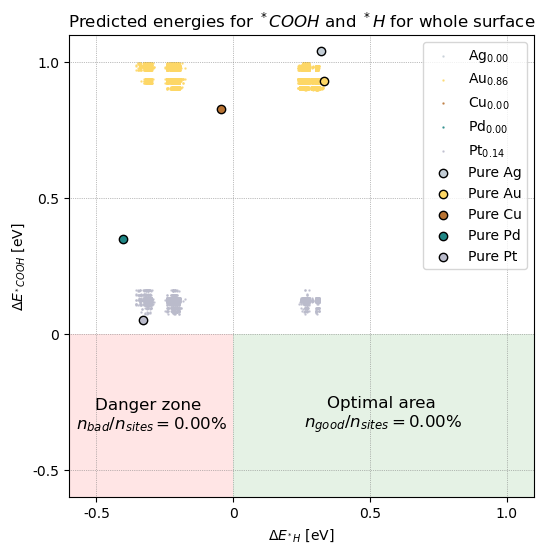

In [86]:
reward_type = "both_corners"
E_top_dict, E_hol_dict, good_hol_sites, n_ratios = sort_energies(surface, reward_type)
deltaEdeltaE_plot(experiment_name+"_deltaEplot", E_hol_dict, E_top_dict, SE_slab_metals, reward_type, show_plot=True)

#### Plotting energies from optimal swim ring surface

I'll try the following surfaces:

Optimal top layer structure - with most possible swim rings

Bottom two layers random distribution of Au and Pt with the same mixture as the top layer



In [116]:
dim_x, dim_y, split = 102, 102, [0, 2, 0, 0, 1]

# Note the stochiometry - used for plotting
stochiometry = dict(zip(metals, np.array(split)/np.sum(split)))
# Make the surface (empty surface)
surface = initialize_surface(dim_x, dim_y, metals, split)
# Change out the top layer for the optimal swim ring surface
n = 35
top_dim_x, top_dim_y = 3*n, 3*n-1
n_adams = int(top_dim_x * top_dim_y / 3)
top_layer = np.reshape(["Pt", "Au", "Au"]*n_adams, (top_dim_x, top_dim_y))
top_layer = top_layer[0:dim_x, 0:dim_y]

# Set the neatly arranged layer
surface["atoms"][:,:,0] = top_layer

# Predict energies on all sites for both adsorbates
surface = precompute_binding_energies_TQDM(surface, dim_x, dim_y, models, predict_G)

Predicting all ΔG:   0%|          | 0/10404 [00:00<?, ?it/s]

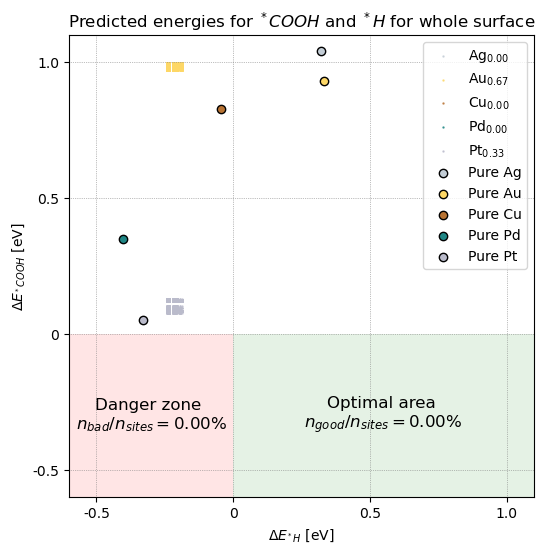

In [117]:
experiment_name = "Au2Pt1_opt_top_layer"
reward_type = "both_corners"
E_top_dict, E_hol_dict, good_hol_sites, n_ratios = sort_energies(surface, reward_type)
deltaEdeltaE_plot(experiment_name+"_deltaEplot", E_hol_dict, E_top_dict, SE_slab_metals, reward_type, show_plot=True)

What does this show?

The "optimal bad hollow sites" were hoped to have a negative binding energy for COOH and a positive binding energy for H. It turns out the model predicts: COOH doesn't bind, H binds.

#Er det ikke sådan, at hvis COOH har en bindingsenergi på -0.12 eV, så får man den optimale energi ud? Og hvornår er det sådan, at man ikke længere får noget energi ud?

#Hvor mange gode sites skal der til, før det er godt?

Man kan ikke både få ingen punkter i danger zone og optimal area, pga. de der bands. Skal man bare acceptere at nogle sites vil lave CO og så prøve at få så mange optimale sites som muligt?

#Could I make a shader map, that values each site in terms of how good a contribution it would make?

A map that the energy plane is multiplied by and them summed for a goodness score. Probably will be better and better closer to E(COOH)=-0.12 eV. Would it be exponentially better closer to the optimal energy?

Hvordan ville det reward map se ud?

Lav en god model for det. Lav en funktion, som kan vurdere en matrice med energier ift. reward map og summe godheden. Det kan så bruges i en stor fed BO runde med kæmpe præcision, så den kan ramme helt rigtigt. Men der er self også 0.05 eV MAE på modellerne, så tættere kommer vi heller ikke. Hvis man ender med kun 3-4 metaller brugt kunne man måske lave ny data med kun de fire for at få bedre accuracy. Men hvis end-result er, at man prøver i laboratoriet at blande præcist den fraction som BO gætter på, så er der nok ikke uendelig præcision i blandingen der heller, og en lille afstand i stochiometrisk afstand gør nok heller ikke noget.

ONSDAG TO DO: Research og tegn et shader reward map, som er accurate


In [115]:
surface["H_E"]

array([[-0.22206245, -0.21266042, -0.22190964, ..., -0.24127693,
        -0.21456751, -0.22190964],
       [-0.2352089 , -0.21266042, -0.2352089 , ..., -0.2352089 ,
        -0.22890465,  0.25090212],
       [-0.22190964, -0.2352089 , -0.2352089 , ..., -0.2352089 ,
        -0.19459543, -0.31425664],
       ...,
       [-0.21102527, -0.21266042, -0.21266042, ..., -0.21102527,
        -0.22442116,  0.26749864],
       [-0.21917659, -0.22442116, -0.21266042, ..., -0.24978499,
        -0.21266042, -0.33964339],
       [-0.22190964,  0.25090212, -0.33964339, ...,  0.26572695,
        -0.31082782, -0.35563108]])

In [73]:
def sort_energies(surface, reward_type): # Just make it return everything all the time
    
    # So this could quite nicely be a dictionary
    
    E_top_dict = {"Pt": [], "Pd": [], "Cu": [], "Ag": [], "Au": []}
    E_hol_dict = {"Pt": [], "Pd": [], "Cu": [], "Ag": [], "Au": []} # Hollow sites that have a neighbour of that atom type and their index match up with the adsorbate on the top-site of that atom.
    
    # Which atoms are around the GOOD hollow sites?
    good_hol_sites = []
    n_sites = 0 # All sites
    n_right_corner = 0  # The good sites
    n_left_corner  = 0  # The bad  sites
    n_diagonal     = 0  # The diagonal sites
    
    for x_top, y_top in [(x, y) for x in range(dim_x) for y in range(dim_y)]: # Mixed order
        for x_diff, y_diff in [(0, 0), (0, -1), (-1, 0)]:                     # Mixed order
            n_sites += 1
            # What are the indices?
            x_hollow = (x_top + x_diff) % dim_x
            y_hollow = (y_top + y_diff) % dim_y
            
            # What are the energies?
            on_top_E = surface["COOH_E"][x_top][y_top]
            hollow_E = surface["H_E"][x_hollow][y_hollow]
            
            # Which atom is the top-site?
            top_site_atom = surface["atoms"][x_top, y_top, 0]
            
            # Append the information to the dicts and lists
            E_top_dict[top_site_atom].append(on_top_E)
            E_hol_dict[top_site_atom].append(hollow_E)
            
            # Find GOOD sites:
            if (on_top_E < 0) and (hollow_E > 0): # Wait have a think about the loops
                # Here is a good site!
                n_right_corner += 1
                # I am interested in knowing which metals are around the hollow sites except for Pt
                atom1 = surface["atoms"][(x_hollow+0)%dim_x, (y_hollow+0)%dim_y, 0]
                atom2 = surface["atoms"][(x_hollow+1)%dim_x, (y_hollow+0)%dim_y, 0]
                atom3 = surface["atoms"][(x_hollow+0)%dim_x, (y_hollow+1)%dim_y, 0]
                good_hol_sites.append([atom1, atom2, atom3])

            if on_top_E < hollow_E: # The on-top binding energy is lower than hollow binding energy. Smaller means binds better
                # Here is a good site!
                n_diagonal += 1

            if on_top_E < 0 and hollow_E < 0:
                #Here is a bad site
                n_left_corner += 1
            
            
    n_left_corner_ratio = n_left_corner / n_sites
    n_right_corner_ratio = n_right_corner / n_sites
    n_diagonal_ratio = n_diagonal / n_sites
    n_ratios = {"left_corner": n_left_corner_ratio, "right_corner": n_right_corner_ratio, "diagonal": n_diagonal_ratio}
    return E_top_dict, E_hol_dict, good_hol_sites, n_ratios

# Make this into a function! And make it save a nice plot. Perhaps ask for a name directly in the function-call
def deltaEdeltaE_plot(filename, E_hol_dict, E_top_dict, SE_slab_metals, reward_type, show_plot):

    fig, ax = plt.subplots(figsize = (6, 6))
    
    # Set the limits for both x and y axes
    ax.set_xlim(-0.6, 1.1)
    ax.set_ylim(-0.6, 1.1)
    
    # Set the major ticks and tick labels
    ax.set_xticks([-0.5, 0, 0.5, 1.0])
    ax.set_xticklabels([-0.5, 0, 0.5, 1.0])
    ax.set_yticks([-0.5, 0, 0.5, 1.0])
    ax.set_yticklabels([-0.5, 0, 0.5, 1.0])
    
    # Set the grid lines
    ax.grid(which='both', linestyle=':', linewidth=0.5, color='gray')
    
    ax.set_title("Predicted energies for $^*COOH$ and $^*H$ for whole surface")
    ax.set_xlabel("$\Delta E_{^*H}$ [eV]")
    ax.set_ylabel("$\Delta E_{^*COOH}$ [eV]")
    
    if reward_type == "right_corner":
        # Create a rectangle patch
        rect = patches.Rectangle((0, 0), 1.1, -0.6, linewidth=1, edgecolor='none', facecolor='green', alpha = 0.1)
    
        # Add the rectangle to the plot
        ax.add_patch(rect)
        
        label_text = f'Optimal area \n$n_{{optimal}} / n_{{sites}} = {100*n_ratios[reward_type]:.2f} \%$' #This can show how many points are in there as well
        label_x = 0.55
        label_y = -0.3
        ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=12)
    
    if reward_type == "diagonal":
        ax.plot([-0.6, 1.5], [-0.6, 1.5], 'k--', alpha = 0.0)  # Plot the diagonal line
        ax.fill_between([-0.6, 1.5], [-0.6, 1.5], -1, where=(y >= -1), color='green', alpha=0.1)  # Fill the area under the line

        label_text = f'Diagonal area \n$n_{{diagonal}} / n_{{sites}} = {100*n_ratios[reward_type]:.2f} \%$' #This can show how many points are in there as well
        label_x = 0.55
        label_y = -0.3
        ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=12)

    if reward_type == "left_corner":
        # Create a rectangle patch
        rect = patches.Rectangle((-0.6, -0.6), 0.6, 0.6, linewidth=1, edgecolor='none', facecolor='red', alpha = 0.1)
    
        # Add the rectangle to the plot
        ax.add_patch(rect)
        
        label_text = f'Danger zone \n$n_{{bad}} / n_{{sites}} = {100*n_ratios[reward_type]:.2f} \%$' #This can show how many points are in there as well
        label_x = -0.3
        label_y = -0.3
        ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=12)

    if reward_type == "both_corners":
        # Create a rectangle patch
        rect = patches.Rectangle((-0.6, -0.6), 0.6, 0.6, linewidth=1, edgecolor='none', facecolor='red', alpha = 0.1)
    
        # Add the rectangle to the plot
        ax.add_patch(rect)
        
        label_text = f'Danger zone \n$n_{{bad}} / n_{{sites}} = {100*n_ratios["left_corner"]:.2f} \%$' #This can show how many points are in there as well
        label_x = -0.3
        label_y = -0.3
        ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=12)

        # Create a rectangle patch
        rect = patches.Rectangle((0, 0), 1.1, -0.6, linewidth=1, edgecolor='none', facecolor='green', alpha = 0.1)
    
        # Add the rectangle to the plot
        ax.add_patch(rect)
        
        label_text = f'Optimal area \n$n_{{good}} / n_{{sites}} = {100*n_ratios["right_corner"]:.2f} \%$' #This can show how many points are in there as well
        label_x = 0.55
        label_y = -0.3
        ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=12)  


    for metal in ['Ag', 'Au', 'Cu', 'Pd', 'Pt']:
        ax.scatter(E_hol_dict[metal], E_top_dict[metal], label = f"{metal}$_{{{stochiometry[metal]:.2f}}}$", s = 0.5, alpha = 0.8, c = metal_colors[metal]) # edgecolor = "black", linewidth = 0.05, 
    
    if True:
        for i, metal in enumerate(SE_slab_metals):
            ax.scatter(DeltaE_H[i], DeltaE_COOH[i], label = "Pure "+metal, marker = "o", c = metal_colors[metal], edgecolors='black')
        
    ax.legend(loc="upper right")
    
    plt.savefig("../figures/DFT_calc_energies/"+filename+".png", dpi = 600, bbox_inches = "tight")
    if show_plot == True:
        plt.show()
    else:
        plt.close()
    return None

/var/folders/_6/524tslys67zcg0hskf43h2y40000gn/T/ipykernel_2266/3937928182.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(labels, rotation=45)


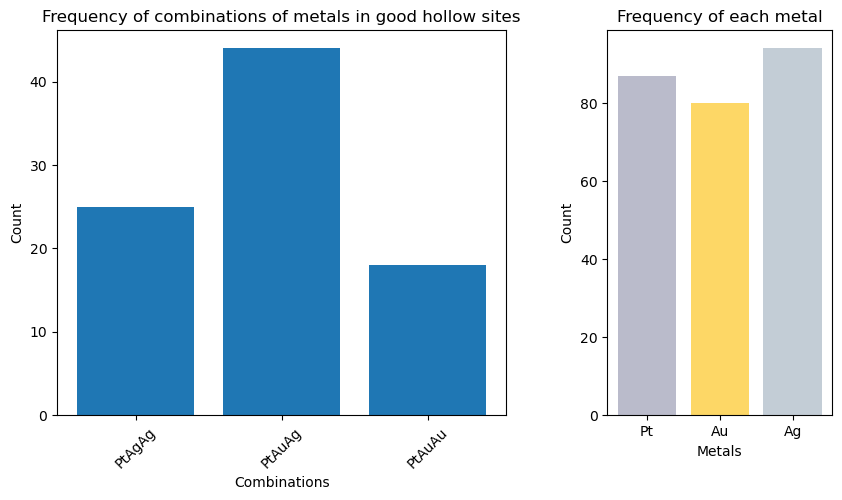

In [210]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create the figure and gridspec
fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[6, 3])

# Plot on the left subplot
good_hol_sites_sorted = sorted(["".join(sorted(x, reverse = True)) for x in good_hol_sites])
good_hol_sites_dict = Counter(good_hol_sites_sorted)

labels = good_hol_sites_dict.keys()
values = good_hol_sites_dict.values()

ax1 = plt.subplot(gs[0])
ax1.bar(labels, values)
ax1.set_xticklabels(labels, rotation=45)
ax1.set_xlabel('Combinations')
ax1.set_ylabel('Count')
ax1.set_title('Frequency of combinations of metals in good hollow sites')

# Plot on the right subplot
ax2 = plt.subplot(gs[1])
good_hol_sites_flat_dict = Counter(np.array(good_hol_sites).flatten())
labels = good_hol_sites_flat_dict.keys()
values = good_hol_sites_flat_dict.values()

colors = [metal_colors[metal] for metal in labels]

ax2.bar(labels, values, color = colors)
ax2.set_xlabel('Metals')
ax2.set_ylabel('Count')
ax2.set_title('Frequency of each metal')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)

plt.savefig("../figures/DFT_calc_energies/"+experiment_name+"_good_sites.png", dpi = 300, bbox_inches = "tight")
# Show the plot
plt.show()

## Bayesian Optimization - Best composition for $n_{optimal}$

In [59]:
def simulate_loss_right_corner(surface_stochiometry):
    ## surface_stochiometry is a 5-len list of probabilities to draw each metal
    surface_stochiometry = np.array(surface_stochiometry) / np.sum(surface_stochiometry)
    dim_x, dim_y, metals = 140, 140, ['Ag', 'Au', 'Cu', 'Pd', 'Pt']
    surface = initialize_surface(dim_x, dim_y, metals, surface_stochiometry)
    
    # Predict energies on all sites for both adsorbates
    surface = precompute_binding_energies_TQDM(surface, dim_x, dim_y, models, predict_G)
    #n_sites = 0
    n_good  = 0
    for x_top, y_top in [(x, y) for x in range(dim_x) for y in range(dim_y)]: # Mixed order
        for x_diff, y_diff in [(0, 0), (0, -1), (-1, 0)]:                     # Mixed order
            #n_sites += 1
            # What are the indices?
            x_hollow = (x_top + x_diff) % dim_x
            y_hollow = (y_top + y_diff) % dim_y
            
            # What are the energies?
            on_top_E = surface["COOH_E"][x_top][y_top]
            hollow_E = surface["H_E"][x_hollow][y_hollow]
            
            # Find GOOD sites:
            if (on_top_E < 0) and (hollow_E > 0):
                # Here is a good site!
                n_good += 1
    return -n_good

def simulate_loss_left_corner(surface_stochiometry):
    ## surface_stochiometry is a 5-len list of probabilities to draw each metal
    surface_stochiometry = np.array(surface_stochiometry) / np.sum(surface_stochiometry)
    metals = ['Ag', 'Au', 'Cu', 'Pd', 'Pt']
    surface = initialize_surface(dim_x, dim_y, metals, surface_stochiometry)
    
    # Predict energies on all sites for both adsorbates
    surface = precompute_binding_energies_TQDM(surface, dim_x, dim_y, models, predict_G)
    #n_sites = 0
    n_bad  = 0
    for x_top, y_top in [(x, y) for x in range(dim_x) for y in range(dim_y)]: # Mixed order
        for x_diff, y_diff in [(0, 0), (0, -1), (-1, 0)]:                     # Mixed order
            #n_sites += 1
            # What are the indices?
            x_hollow = (x_top + x_diff) % dim_x
            y_hollow = (y_top + y_diff) % dim_y
            
            # What are the energies?
            on_top_E = surface["COOH_E"][x_top][y_top]
            hollow_E = surface["H_E"][x_hollow][y_hollow]
            
            # Find BAD sites:
            if (on_top_E < 0) and (hollow_E < 0): # Low COOH and low H
                # Here is a bad site!
                n_bad += 1
    return n_bad

def simulate_loss_both_corners(surface_stochiometry):
    ## surface_stochiometry is a 5-len list of probabilities to draw each metal
    surface_stochiometry = np.array(surface_stochiometry) / np.sum(surface_stochiometry)
    metals = ['Ag', 'Au', 'Cu', 'Pd', 'Pt']
    surface = initialize_surface(dim_x, dim_y, metals, surface_stochiometry)
    
    # Predict energies on all sites for both adsorbates
    surface = precompute_binding_energies_TQDM(surface, dim_x, dim_y, models, predict_G)
    #n_sites = 0
    n_loss  = 0
    for x_top, y_top in [(x, y) for x in range(dim_x) for y in range(dim_y)]: # Mixed order
        for x_diff, y_diff in [(0, 0), (0, -1), (-1, 0)]:                     # Mixed order
            #n_sites += 1
            # What are the indices?
            x_hollow = (x_top + x_diff) % dim_x
            y_hollow = (y_top + y_diff) % dim_y
            
            # What are the energies?
            on_top_E = surface["COOH_E"][x_top][y_top]
            hollow_E = surface["H_E"][x_hollow][y_hollow]
            
            # Find BAD sites:
            if (on_top_E < 0) and (hollow_E < 0): # Low COOH and low H
                # Here is a bad site!
                n_loss += 1

            # Find GOOD sites:
            if (on_top_E < 0) and (hollow_E > 0):
                # Here is a good site!
                n_loss -= 1
    return n_loss

## Make a loss function, that rewards points for being under the diagonal
def simulate_loss_diagonal(surface_stochiometry):
        ## surface_stochiometry is a 5-len list of probabilities to draw each metal
    surface_stochiometry = np.array(surface_stochiometry) / np.sum(surface_stochiometry)
    dim_x, dim_y, metals = 140, 140, ['Ag', 'Au', 'Cu', 'Pd', 'Pt']
    surface = initialize_surface(dim_x, dim_y, metals, surface_stochiometry)
    
    # Predict energies on all sites for both adsorbates
    surface = precompute_binding_energies_TQDM(surface, dim_x, dim_y, models, predict_G)
    #n_sites = 0
    n_under_diagonal  = 0
    for x_top, y_top in [(x, y) for x in range(dim_x) for y in range(dim_y)]: # Mixed order
        for x_diff, y_diff in [(0, 0), (0, -1), (-1, 0)]:                     # Mixed order
            #n_sites += 1
            # What are the indices?
            x_hollow = (x_top + x_diff) % dim_x
            y_hollow = (y_top + y_diff) % dim_y
            
            # What are the energies?
            on_top_E = surface["COOH_E"][x_top][y_top]
            hollow_E = surface["H_E"][x_hollow][y_hollow]
            
            # Find GOOD sites:
            if on_top_E < hollow_E: # The on-top binding energy is lower than hollow binding energy. Smaller means binds better
                # Here is a good site!
                n_under_diagonal += 1

    return -n_under_diagonal

In [81]:
import numpy as np
from skopt import gp_minimize
from skopt.space import Space
#from skopt.utils import normalize_dimensions

dim_x, dim_y = 100, 100
experiment_name = "AuPt_100by100_10its_right_corners"

# Define the Search Space
space = [(0.0, 1.0)] * 5
# AuPt space
AuPt_space = [(0.0, 0.00001), (0.0, 1.0), (0.0, 0.00001), (0.0, 0.00001), (0.0, 1.0)]

## Normalize the search space dimensions
#space = normalize_dimensions(space)

# Initialize the Bayesian Optimizer
optimizer = gp_minimize(
    simulate_loss_right_corner,
    AuPt_space,
    n_calls=10, # Number of evaluations of the loss function
    random_state=42, # Set a random seed for reproducibility
    n_jobs = -1)

# Retrieve the intermediate results
results = optimizer.x_iters
losses = optimizer.func_vals

# Print the intermediate results
for i, result in enumerate(results):
    loss = losses[i]
    print(f"Iteration {i+1}: Surface Stochiometry: {result}, Loss: {loss}")

# Retrieve the optimal solution
optimal_surface_stochiometry = optimizer.x
optimal_loss = optimizer.fun  # Negate the loss to retrieve the maximized value

print("Optimal Surface Stochiometry:", optimal_surface_stochiometry)
print("Optimal Loss:", optimal_loss)

Predicting all ΔG:   0%|          | 0/19600 [00:00<?, ?it/s]

Predicting all ΔG:   0%|          | 0/19600 [00:00<?, ?it/s]

Predicting all ΔG:   0%|          | 0/19600 [00:00<?, ?it/s]

Predicting all ΔG:   0%|          | 0/19600 [00:00<?, ?it/s]

Predicting all ΔG:   0%|          | 0/19600 [00:00<?, ?it/s]

Predicting all ΔG:   0%|          | 0/19600 [00:00<?, ?it/s]

Predicting all ΔG:   0%|          | 0/19600 [00:00<?, ?it/s]

Predicting all ΔG:   0%|          | 0/19600 [00:00<?, ?it/s]

Predicting all ΔG:   0%|          | 0/19600 [00:00<?, ?it/s]

Predicting all ΔG:   0%|          | 0/19600 [00:00<?, ?it/s]

Iteration 1: Surface Stochiometry: [7.96542986860233e-06, 0.18343478986616382, 7.796910002727696e-06, 5.968501579464872e-06, 0.44583275285359125], Loss: 0
Iteration 2: Surface Stochiometry: [9.997491581800292e-07, 0.45924889196586727, 3.337086111390219e-06, 1.4286681792194083e-06, 0.650888472948853], Loss: 0
Iteration 3: Surface Stochiometry: [5.641157902710027e-07, 0.7219987722668249, 9.385527090157505e-06, 7.787658410143286e-09, 0.9922115592912177], Loss: 0
Iteration 4: Surface Stochiometry: [6.174815096277167e-06, 0.611653160488281, 7.066305219717408e-08, 2.3062425041415763e-07, 0.5247746602583893], Loss: 0
Iteration 5: Surface Stochiometry: [3.998609717152556e-06, 0.046665663213615434, 9.737555188414595e-06, 2.327713404303043e-06, 0.09060643453282081], Loss: 0
Iteration 6: Surface Stochiometry: [6.183860093330875e-06, 0.38246199126716285, 9.832308858067885e-06, 4.6676289324798005e-06, 0.8599404067363208], Loss: 0
Iteration 7: Surface Stochiometry: [6.803075385877799e-06, 0.45049925

RIGHT CORNER:
From 100by100 100its results:
Optimal Surface Stochiometry: [1.0, 1.0, 0.0, 1.0, 0.7756340795658901]
Optimal Loss: 150

From 140by140 50 its result:
Optimal Surface Stochiometry: [0.8953318995954538, 0.738086071173332, 0.0, 0.5932504594623, 0.5487552835398027]
Optimal Loss: 294

From 140by140 100 its result:
Optimal Surface Stochiometry: [0.8458380615695716, 1.0, 0.0, 0.5242110298660663, 0.689633397655569]
Optimal Loss: 301

DIAGONAL:
Optimal Surface Stochiometry: [1.0, 1.0, 0.0, 0.0, 0.6098243992113722]
Optimal Loss: 2111

LEFT CORNER:
Optimal Surface Stochiometry: [0.05641157902710027, 0.7219987722668249, 0.9385527090157504, 0.0007787658410143285, 0.9922115592912177]
Optimal Loss: -17

In [57]:
# Plain colors list
colors_list = [metal_colors[metal] for metal in metals]

In [55]:
experiment_name

'test_left_corner_graphics'

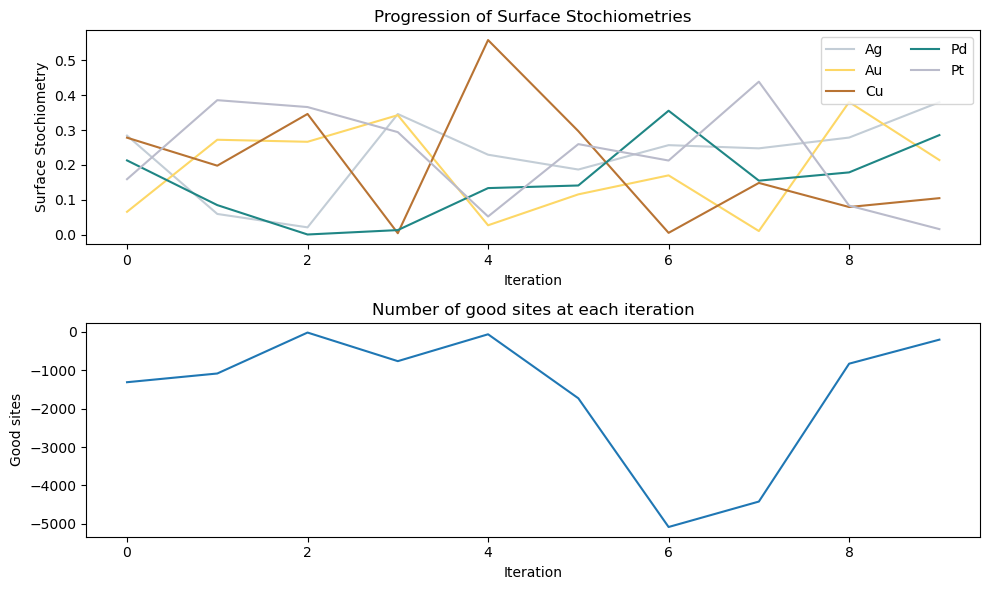

In [58]:
## I would like a plot that shows the progression in the predicted stochiometries and the resulting losses

# Plot the progression of surface stochiometries #ChatGPT
fig = plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
for i, stoch in enumerate(np.array([stoch/np.sum(stoch) for stoch in results]).T):
    plt.plot(stoch, c = colors_list[i], label = metals[i]) # HERE - Trying to make it plot each line in the appropriate colors
plt.title('Progression of Surface Stochiometries')
plt.xlabel('Iteration')
plt.ylabel('Surface Stochiometry')
plt.legend(loc="upper right", ncol = 2)
#plt.xlim(-5, np.shape(results)[0]*1.05)

# Plot the losses as a function of iteration
plt.subplot(2, 1, 2)
plt.plot(-losses)
plt.title('Number of good sites at each iteration')
plt.xlabel('Iteration')
plt.ylabel('Good sites')

# Adjust the layout of the subplots
plt.tight_layout()

# Save figure
#experiment_name = "140by140_100its_diagonal"
plt.savefig("../figures/DFT_calc_energies/"+experiment_name+"_progression.png", dpi = 300, bbox_inches = "tight")

# Show the plot
plt.show()

It seems there is a lot of variation even on borderline the same stochiometry. That is probably no good, but there has to be a tradeoff between number of iterations and precision. 

Maybe the plot should show the best guess stochiometry

at 100by100 there is still variation, maybe I should go for a bit larger surface? So it can dial in the finer details

140by140 is about double the size of 100by100, which kind of makes sense because of sqrt(2).

Try another loss function! That rewards binding COOH better and H worse in general. Points awarded for going down right Maybe points for going under the diagonal?

It's really hard to squish that many points in the lower right corner.

I could do the final "measuring" on a really large surface to get an accurate percentage

I should show the before/after of optimizing for dots in the lower right corner/under the diagonal etc.

Maybe I should try some optimizations without Cu in the mix, since it seems like the BO hates Cu. But I guess it finds out all by itself. But I guess Cu might be fine in the diagonal case. Also think about the logic behind the diagonal case. What does it mean to be on the diagonal? 
On the diagonal: COOH and H binds equally well.
Under the diagonal: COOH binds better than H.
With a larger voltage, COOH binds better and H worse. 

A comparison between a non-optimized deltaE/deltaE-plot and an optimized with BO-one would be cool. Then the tiny improvements could be shown.

Maybe I should look at the span of the stochiometries, that all result in almost optimal (at least the best found). Are they almost similar?

I could make a sliding change in the deltaE/deltaE-plot from the standard even distribution to the optimized stochiometry and plot them as a gif. This would show the efforts to move the energies towards the desired area.

I could make occupancy plots with the unoptimized and optimized stochiometries. 

If I make an optimization of just the three metals that is seen to actually do something, then I could make a 2D triangle plot of the stochiometries tried and where the optimal zone is. But it might not be so important, if the corner is the most important part. Holy guac tho, not much is possible to push down there. Maybe that's why it's so hard to get the catalyst to work. 

Argument for at man godt kan bruge BOGP: "The idea is to approximate the function using a Gaussian process. In other words the function values are assumed to follow a multivariate gaussian." Det lader jo også til, at når man ændrer lidt i kompositionen så ændrer man bare nogle få sites, og der ændrer loss'et en lille smule. Om det svarer til en multivariate gaussian er ikke sikkert, men små ændringer i input skulle gerne give små ændringer i output.

I wonder what would happen, if I tried to get BO to find the best surface only using Pt and Au. There is some logic behind the swim rings idea, but from the BO it looks like more metals are needed to tailor the energies more precisely.

Maybe show what would happen in the four corners:
Upper left: COOH binds too late, overpotential is needed. H binds too well, but would probs be removed by the potential needed to put COOH on. 
Lower left: Both COOH and H binds on V=0. Risk of CO creation.
Upper right: Neither COOH nor H binds at V=0.
Lower right: COOH binds before V=0 and H doesn't - Yay!

Maybe I should make a BO where I reward the BO for limiting the number of points in the lower left corner, as this would seem to be the danger zone. 

### Gif that shows improvements in "optimal energies" with Bayesian Optimization with Gaussian Processes

In [ ]:
reward_type = "corner"
dim_x, dim_y, metals = 140, 140, ['Ag', 'Au', 'Cu', 'Pd', 'Pt']

even_split_stoch = [0.2, 0.2, 0.2, 0.2, 0.2]
optimal_stoch = {"corner": [0.8458380615695716, 1.0, 0.0, 0.5242110298660663, 0.689633397655569], "diagonal": [1.0, 1.0, 0.0, 0.0, 0.6098243992113722]}

#Linear interpolation between two 5D points
num_interpolations = 58  # Number of interpolated points
interpolated_points = linear_interpolation(even_split_stoch, optimal_stoch[reward_type], num_interpolations)
for i, split in tqdm(enumerate(interpolated_points)):
    split = np.array(split)/np.sum(split)
    stochiometry = dict(zip(metals, split))
    surface = initialize_surface(dim_x, dim_y, metals, split)
    # Predict energies on all sites for both adsorbates
    surface = precompute_binding_energies_TQDM(surface, dim_x, dim_y, models, predict_G)

    E_top_dict, E_hol_dict, n_ratio, n_good, good_hol_sites = sort_energies(surface, reward_type)
    deltaEdeltaE_plot("Gif_corner/"+str(i), E_hol_dict, E_top_dict, SE_slab_metals, reward_type, show_plot = False)

In [ ]:
reward_type = "diagonal"
dim_x, dim_y, metals = 140, 140, ['Ag', 'Au', 'Cu', 'Pd', 'Pt']

even_split_stoch = [0.2, 0.2, 0.2, 0.2, 0.2]
optimal_stoch = {"corner": [0.8458380615695716, 1.0, 0.0, 0.5242110298660663, 0.689633397655569], "diagonal": [1.0, 1.0, 0.0, 0.0, 0.6098243992113722]}

#Linear interpolation between two 5D points
num_interpolations = 60  # Number of interpolated points
interpolated_points = linear_interpolation(even_split_stoch, optimal_stoch[reward_type], num_interpolations)
for i, split in tqdm(enumerate(interpolated_points)):
    split = np.array(split)/np.sum(split)
    stochiometry = dict(zip(metals, split))
    surface = initialize_surface(dim_x, dim_y, metals, split)
    # Predict energies on all sites for both adsorbates
    surface = precompute_binding_energies_TQDM(surface, dim_x, dim_y, models, predict_G)

    E_top_dict, E_hol_dict, n_ratio, n_good, good_hol_sites = sort_energies(surface, reward_type)
    deltaEdeltaE_plot("Gif_diagonal/"+str(i), E_hol_dict, E_top_dict, SE_slab_metals, reward_type, show_plot = False)

In [7]:
## Stitch together the images
import imageio

for reward_type in ["corner", "diagonal"]:
    images = []
    for filename in ["../figures/DFT_calc_energies/Gif_"+reward_type+"/"+str(n)+".png" for n in range(60)]:
        images.append(imageio.imread(filename))
    imageio.mimsave("../figures/DFT_calc_energies/Gif_"+reward_type+"/Såerdergif.gif", images, duration = 0.1, transparent=True)

/var/folders/_6/524tslys67zcg0hskf43h2y40000gn/T/ipykernel_983/207977756.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


In [8]:
import imageio
from PIL import Image

for reward_type in ["corner", "diagonal"]:
    images = []
    for n in range(60):
        filename = "../figures/DFT_calc_energies/Gif_" + reward_type + "/" + str(n) + ".png"
        img = Image.open(filename)
        img = img.convert("RGB")  # Convert to RGB to remove transparency
        images.append(np.array(img))
    imageio.mimsave(
        "../figures/DFT_calc_energies/Gif_" + reward_type + "/Såerdergif.gif",
        images,
        duration=0.1
    )


In [9]:
import imageio

for reward_type in ["corner", "diagonal"]:
    images = []
    for filename in ["../figures/DFT_calc_energies/Gif_"+reward_type+"/"+str(n)+".png" for n in range(60)]:
        images.append(imageio.imread(filename))
    output_filename = "../figures/DFT_calc_energies/Gif_"+reward_type+"/Såerdergif_compressed.gif"
    imageio.mimsave(output_filename, images, duration=0.1, subrectangles=True)
    print(f"Compressed GIF saved as: {output_filename}")


/var/folders/_6/524tslys67zcg0hskf43h2y40000gn/T/ipykernel_983/3502157391.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


Compressed GIF saved as: ../figures/DFT_calc_energies/Gif_corner/Såerdergif_compressed.gif
Compressed GIF saved as: ../figures/DFT_calc_energies/Gif_diagonal/Såerdergif_compressed.gif


In [220]:
def linear_interpolation(p1, p2, n):
    # p1, p2 are the 5D points
    # n is the number of interpolated points (excluding the endpoints)

    # Convert the points to numpy arrays
    p1 = np.array(p1)
    p2 = np.array(p2)

    # Calculate the interpolation parameter step size
    step_size = 1 / (n + 1)

    # Generate the interpolated points
    interpolated_points = []
    for i in range(n + 2):
        t = i * step_size
        interpolated_point = p1 + t * (p2 - p1)
        interpolated_points.append(interpolated_point.tolist())

    return interpolated_points

In [63]:
surface["atoms"][:, :, 0]

array([['Au', 'Cu', 'Au', ..., 'Pd', 'Au', 'Pd'],
       ['Pt', 'Pd', 'Cu', ..., 'Ag', 'Pt', 'Pd'],
       ['Pd', 'Pt', 'Ag', ..., 'Ag', 'Au', 'Pd'],
       ...,
       ['Pt', 'Au', 'Cu', ..., 'Ag', 'Pt', 'Au'],
       ['Pt', 'Pt', 'Au', ..., 'Pd', 'Au', 'Pt'],
       ['Ag', 'Au', 'Pd', ..., 'Ag', 'Cu', 'Cu']], dtype='<U2')

#### Findings

It seems like Pd might be useless, because it's not good enough to make good COOH top-sites and it's not bad anough to make shitty hollow sites. Pd was not useless lmao.

#### Functions

In [5]:
def initialize_surface(dim_x, dim_y, metals, split): #Is still random - could be used with a seed in the name of reproduceability
    dim_z = 3
    
    surf_atoms = create_surface(dim_x, dim_y, metals, split)
    
    # Binding energies
    surf_COOH_E = np.reshape([np.nan]*dim_x*dim_y, (dim_x, dim_y))# On-top sites
    surf_H_E    = np.reshape([np.nan]*dim_x*dim_y, (dim_x, dim_y))# Hollow sites
    
    surf = {"atoms": surf_atoms,\
            "COOH_E": surf_COOH_E, "H_E": surf_H_E}
    return surf

def create_surface(dim_x, dim_y, metals, split):
    dim_z = 3
    num_atoms = dim_x*dim_y*dim_z
    if np.sum(split) != 1.0:
        # This split is not weighted properly, I'll fix it
        split = split / np.sum(split)
    if split == "Even":
        proba = [1.0 / len(metals) for n in range(len(metals))] 
        surface = np.random.choice(metals, num_atoms, p=proba)
    else:
        surface = np.random.choice(metals, num_atoms, p=split)
    surface = np.reshape(surface, (dim_x, dim_y, dim_z)) #Reshape list to the
    return surface

def precompute_binding_energies_TQDM(surface, dim_x, dim_y, models, predict_G_function): #TJEK I think this function can go faster if I make all the data first appended to a list, then to a PD and then 
    for x, y in tqdm([(x, y) for x in range(dim_x) for y in range(dim_y)], desc = r"Predicting all ΔG", leave = False): # I could randomise this, so I go through all sites in a random order
        
        ads = "H"
        surface["H_E"][x][y] = predict_G_function(surface["atoms"], x, y, ads, models) ## A new function that wraps/uses the XGBoost model
        
        ads = "COOH"
        surface["COOH_E"][x][y] = predict_G_function(surface["atoms"], x, y, ads, models) ## A new function that wraps/uses the XGBoost model

    return surface

def predict_G(surface, site_x, site_y, adsorbate, models):
    if adsorbate == "H":
        vector_df = pd.DataFrame([hollow_site_vector(surface, site_x, site_y)], columns = [f"feature{n}" for n in range(55)])
        vector_DM = pandas_to_DMatrix(vector_df)
        G = models["H"].predict(vector_DM)[0]
        return G
    
    if adsorbate == "COOH":
        vector_df = pd.DataFrame([on_top_site_vector(surface, site_x, site_y)], columns = [f"feature{n}" for n in range(20)]) # Tjek - er det ikke "adsorbate" + features?
        vector_DM = pandas_to_DMatrix(vector_df)
        G = models["COOH"].predict(vector_DM)[0]
        return G
    
def on_top_site_vector(surface, site_x, site_y): # I should have done modulo to dim_x and dim_y
    dim_x, dim_y = np.shape(surface)[0], np.shape(surface)[1]
    site1 = [surface[site_x, site_y, 0]]# Make a one-hot encoded vector of the very site here! Add at the beginning 
    site1_count = [site1.count(metals[n]) for n in range(len(metals))]
    
    top6 = [surface[site_x % dim_x, (site_y-1) % dim_y, 0], surface[site_x % dim_x, (site_y+1) % dim_y, 0], surface[(site_x-1) % dim_x, site_y % dim_y, 0], surface[(site_x+1) % dim_x, site_y % dim_y, 0], surface[(site_x-1) % dim_x, (site_y+1) % dim_y, 0], surface[(site_x+1) % dim_x, (site_y-1) % dim_y, 0]]
    top6_count = [top6.count(metals[n]) for n in range(len(metals))]
    
    mid3 = [surface[(site_x-1) % dim_x, (site_y-1) % dim_y,1], surface[site_x % dim_x, (site_y-1) % dim_y,1], surface[(site_x-1) % dim_x, site_y % dim_y,1]]
    mid3_count = [mid3.count(metals[n]) for n in range(len(metals))]
    
    bot3 = [surface[(site_x-1) % dim_x, (site_y-1) % dim_y, 2], surface[(site_x-1) % dim_x, (site_y+1) % dim_y, 2], surface[(site_x+1) % dim_x, (site_y-1) % dim_y, 2]]
    bot3_count = [bot3.count(metals[n]) for n in range(len(metals))]
    
    return site1_count + top6_count + mid3_count + bot3_count

metals = ['Ag', 'Au', 'Cu', 'Pd', 'Pt']
three_metals_combinations = [] #List of possible combinations of the three
# Der skal være 35, ikke 125

for a in metals:
    for b in metals:
        for c in metals:
            three_metals_combinations.append(''.join(sorted([a, b, c])))
            
# Remove duplicates
three_metals_combinations = list(dict.fromkeys(three_metals_combinations)) # Let's encode it in a better way later

def hollow_site_vector(surface, site_x, site_y): #Now with adsorbate encoding
    
    # First encode the 3 neighbours
    blues = [surface[(site_x+1) % dim_x, site_y, 0], surface[site_x, (site_y+1) % dim_y, 0], surface[(site_x+1) % dim_x, (site_y+1) % dim_y, 0]]
    blues = "".join(sorted(blues))
    idx = three_metals_combinations.index(blues)
    blues = 35*[0]
    blues[idx] = 1
    
    # Then the next neighbours (green)
    greens = [surface[(site_x+2) % dim_x, site_y, 0], surface[site_x, (site_y+2) % dim_y, 0], surface[site_x, site_y, 0]]
    greens_count = [greens.count(metals[n]) for n in range(len(metals))]
    
    # Then the next neighbours (brown) # Kunne gøres smartere med list comprehension og to lister med +- zipped
    browns = [surface[(site_x + a) % dim_x, (site_y + b) % dim_y, c] for a, b, c in zip([1, 2, 2, 1, -1, -1], [2, 1, -1, -1, 1, 2], [0, 0, 0, 0, 0, 0])]
    browns_count = [browns.count(metals[n]) for n in range(len(metals))]
    
    # Then the three downstairs neighbours
    yellows = [surface[(site_x + a) % dim_x, (site_y + b) % dim_y, c] for a, b, c in zip([0, 1, 0], [0, 0, 1], [1, 1, 1])]
    yellows_count = [yellows.count(metals[n]) for n in range(len(metals))]
    
    # Then the purples downstairs
    purples = [surface[(site_x + a) % dim_x, (site_y + b) % dim_y, c] for a, b, c in zip([1, -1, 1], [-1, 1, 1], [1, 1, 1])]
    purples_count = [purples.count(metals[n]) for n in range(len(metals))]
    
    return blues + greens_count + browns_count + yellows_count + purples_count

def pandas_to_DMatrix(df):#, label):
    label = pd.DataFrame(np.random.randint(2, size=len(df)))
    DMatrix = xgb.DMatrix(df)#, label=label)
    return DMatrix

#### Training models for COOH and H

In [9]:
def correct_DFT_energy_COOH_DFT(molecules_dict, E_COOH, E_slab):
    return E_COOH - E_slab - molecules_dict["CO2"] - 1/2*molecules_dict["H2"]

def correct_DFT_energy_H_DFT(molecules_dict, E_H, E_slab):
    return E_H - E_slab - 1/2*molecules_dict["H2"]

##### Making features

In [20]:
# Specify metals
metals = ['Ag', 'Au', 'Cu', 'Pd', 'Pt']
alloy = ''.join(metals)

# Specify name of databases
db_name_H = 'H_out.db'
db_name_COOH = 'COOH_C_adsorbed_out.db'
db_name_slab = "slabs_out.db"

# Initiate feature readers
reader_H = FccStandard111(metals)
reader_COOH = OntopStandard111(metals)

site_ids_H = [16, 17, 18]

# Initiate counters of rejected samples
rejected_H = 0
rejected_COOH = 0

# Writer headers to files
with open(f'{features_folder}H_DFT_features.csv', 'w') as file_H:
    column_names = [f"feature{n}" for n in range(55)]
    column_names.append('G_ads (eV)')
    column_names.append('slab db row')
    column_names.append(f'{db_name_H}row')
    file_H.write(",".join(column_names))
    
# Writer headers to files
with open(f'{features_folder}COOH_DFT_features.csv', 'w') as file_COOH:
    column_names = [f"feature{n}" for n in range(20)]
    column_names.append('G_ads (eV)')
    column_names.append('slab db row')
    column_names.append(f'{db_name_COOH}row')
    file_COOH.write(",".join(column_names))
    
# Load HEA(111) databases
with connect(f'{db_folder}{db_name_H}') as db_H,\
     connect(f'{db_folder}{db_name_COOH}') as db_COOH,\
     connect(f'{db_folder}{db_name_slab}') as db_slab,\
     open(f'{features_folder}H_DFT_features.csv', 'a') as file_H,\
     open(f'{features_folder}COOH_DFT_features.csv', 'a') as file_COOH:
    #print("A1")
    # Iterate through slabs without adsorbates
    for row_slab in db_slab.select('energy', H=0, C=0, O=0): # This doesn't even trigger lmao
        #print("A2")
        # Iterate through the two adsorbates
        for ads in ['COOH', 'H']:
            #print("A3")
            # Set adsorbate-specific parameters
            if ads == 'COOH':
                db = db_COOH
                kw = {'C': 1,'O': 2, 'H': 1}
                db_name = db_name_COOH
                out_file = file_COOH

            elif ads == 'H':
                db = db_H
                kw = {'O': 0, 'H': 1}
                db_name = db_name_H
                out_file = file_H
                ads_atom = "H"

            # Set counter of matched slabs between the databases to zero
            n_matched = 0

            # Get the corresponding slab with adsorbate
            for row in db.select('energy', **kw, **row_slab.count_atoms()):
                #print("A4")
                # If symbols match up
                if row.symbols[:-len(ads)] == row_slab.symbols:
                    #print("A5")
                    # Increment the counter of matched structures
                    n_matched += 1

                    # Get atoms object
                    atoms = db.get_atoms(row.id)

                    # If the adsorbate is *COOH
                    if ads == 'COOH':
                        # Make slab instance
                        slab = Slab(atoms, ads=ads, ads_atom='C')

                        # Get adsorption site elements as neighbors within a radius
                        site_elems, site = slab.get_adsorption_site(radius=2.6, hollow_radius=2.6)

                        # If the site does not consist of exactly one atom, then skip this sample
                        # as the *OH has moved too far away from an on-top site
                        try:
                            if len(site_elems) !=1:
                                rejected_COOH += 1
                                #slab.view()
                                continue
                        except TypeError:
                            print(site_elems, site)
                            print(row_slab.id, row.id)
                            slab.view()
                            exit()

                        # Get features of structure
                        features = reader_COOH.get_features(slab, radius=2.6)
                        
                        ### This part is now adsorbate-specific ###
                        # Get adsorption energy
                        E_ads = correct_DFT_energy_COOH_DFT(molecules_dict, row.energy, row_slab.energy) # This is the new formula

                        # Write output to file
                        features = ','.join(map(str, features))
                        out_file.write(f'\n{features},{E_ads:.6f},{row_slab.id},{row.id}')

                    # Else, if the adsorbate is H*
                    elif ads == 'H':
                        
                        atoms = atoms.repeat((3, 3, 1))
                        slab = Slab(atoms, ads=ads, ads_atom=ads_atom)
                        chemical_symbols = atoms.get_chemical_symbols()
                        #view(atoms)
                        H_index = [i for i, x in enumerate(chemical_symbols) if x == "H"][4]
                        
                        all_distances = atoms.get_distances([n for n in list(range(len(chemical_symbols))) if n != H_index], H_index)
                        site_ids_H = np.argpartition(all_distances, 2)[0:3]
                        site_ids_H = [x+1 if x>229 else x for x in site_ids_H] #Compensates for the removal of an H, so that the indices above 229 are not one too small
                        #print("site_ids_H: ", site_ids_H)
                        # Get hollow site planar corner coordinates
                        site_atoms_pos_orig = atoms.positions[site_ids_H, :2]

                        # Get expanded triangle vertices
                        site_atoms_pos = expand_triangle(site_atoms_pos_orig, expansion=1.45)

                        # Get position of adsorbate atom (with atom index XXX 20 XXX)
                        ads_pos = atoms.positions[H_index][:2]

                        # If the H is outside the expanded fcc triangle,
                        # then it is most likely in an hcp site, that is not
                        # being modeled
                        if not inside_triangle(ads_pos, site_atoms_pos):
                            rejected_H += 1
                            continue

                        # Get features of structure
                        features = reader_H.get_features(slab, radius=2.6, site_ids=site_ids_H)

                        ### This part is now adsorbate-specific ###
                        # Get adsorption energy
                        E_ads = correct_DFT_energy_H_DFT(molecules_dict, row.energy, row_slab.energy) # This is the new formula
                        
                        # Write output to file
                        features = ','.join(map(str, features))
                        out_file.write(f'\n{features},{E_ads:.6f},{row_slab.id},{row.id}')

            if n_matched > 1:
                print(f'[INFO] {n_matched} {ads} and slab matched for row {row_slab.id} in {db_name_slab}')

# Print the number of rejected samples to screen
print('rejected COOH samples: ', rejected_COOH)
print('rejected H samples: ', rejected_H)

[INFO] 9 COOH and slab matched for row 1 in slabs_out.db
[INFO] 9 H and slab matched for row 1 in slabs_out.db
[INFO] 9 COOH and slab matched for row 2 in slabs_out.db
[INFO] 9 H and slab matched for row 2 in slabs_out.db
[INFO] 9 COOH and slab matched for row 3 in slabs_out.db
[INFO] 9 H and slab matched for row 3 in slabs_out.db
[INFO] 9 COOH and slab matched for row 4 in slabs_out.db
[INFO] 8 H and slab matched for row 4 in slabs_out.db
[INFO] 9 COOH and slab matched for row 5 in slabs_out.db
[INFO] 9 H and slab matched for row 5 in slabs_out.db
[INFO] 9 COOH and slab matched for row 6 in slabs_out.db
[INFO] 9 H and slab matched for row 6 in slabs_out.db
[INFO] 9 COOH and slab matched for row 7 in slabs_out.db
[INFO] 9 H and slab matched for row 7 in slabs_out.db
[INFO] 9 COOH and slab matched for row 8 in slabs_out.db
[INFO] 9 H and slab matched for row 8 in slabs_out.db
[INFO] 9 COOH and slab matched for row 9 in slabs_out.db
[INFO] 9 H and slab matched for row 9 in slabs_out.db
[

##### Training models

/Users/marcusnorgaardweng/miniforge3/envs/PUK/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


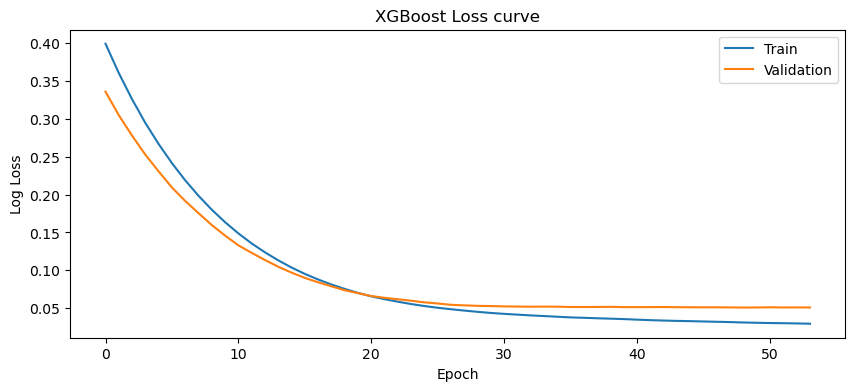

Training score:  0.9911966093244539
Validation score:  0.9764931285341023


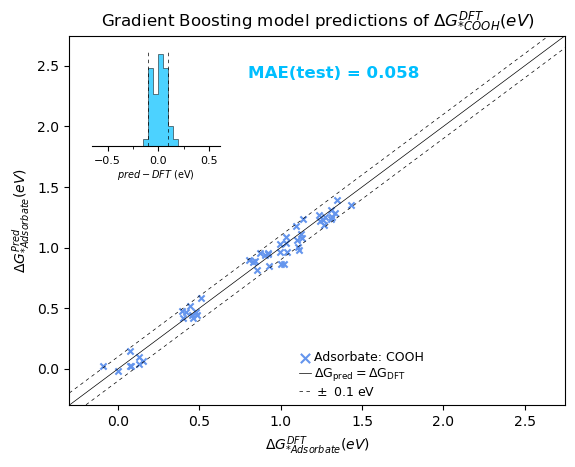

In [11]:
feature_folder = "../csv_features/"
filename = "COOH_DFT_features.csv"

COOH_df = pd.read_csv(feature_folder + filename)
full_df = pd.concat([COOH_df], axis = 0)
all_cols = full_df.columns
#Seperate the energies and remove the useless columns

X = full_df.loc[:, :all_cols[-4]]
y = full_df[["G_ads (eV)"]]

# Prepare data for XGBoost

#shuffle and split
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size = 0.2)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5)

# Prepare XGBoost 
eval_set = [(X_train, y_train), (X_val, y_val)]
XGBModel_COOH =  XGBRegressor(learning_rate = 0.1 #learning rate
                                , max_depth = 5     #maximum tree depth
                                , n_estimators = 500 #number of boosting rounds
                                , n_jobs = 8 #number of threads
                                , use_label_encoder = False)

XGBModel_COOH.fit(X_train, y_train
                       , eval_set = eval_set
                       , early_stopping_rounds = 5
                       , eval_metric = ["mae"]
                       , verbose = False) #evals

# Save model in the /models folder
XGBModel_COOH.save_model("../models/"+"COOH_DFT.model")

learning_curve(XGBModel_COOH)

score = XGBModel_COOH.score(X_train, y_train) #Det må man ikke før den er blevet trænet
print("Training score: ", score)

score = XGBModel_COOH.score(X_val, y_val) #Det må man ikke før den er blevet trænet
print("Validation score: ", score)
figure_folder = "../figures/DeltaG_models"
single_parity_plot(XGBModel_COOH, X_test, y_test, "COOH", "COOH") ## Maybe I should make a new line with MAE_avg
#single_parity_plot(XGBModel_H_Pro, X_test, y_test, "H", "H")

/Users/marcusnorgaardweng/miniforge3/envs/PUK/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


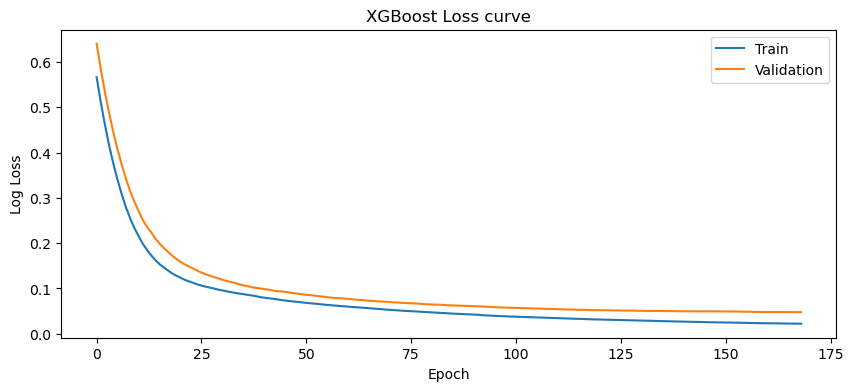

Training score:  0.9831760140145627
Validation score:  0.925897438789119


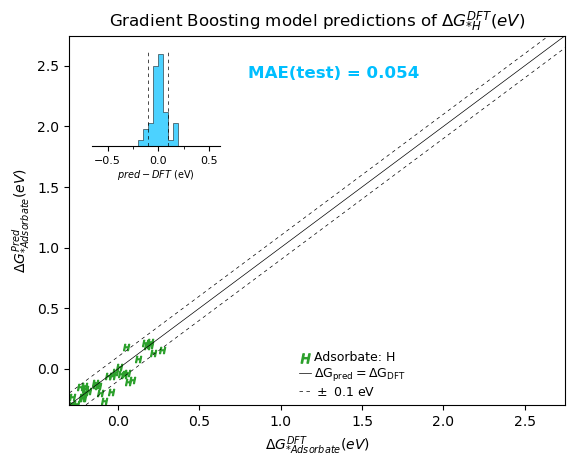

In [21]:
feature_folder = "../csv_features/"
filename = "H_DFT_features.csv"

H_df = pd.read_csv(feature_folder + filename)
full_df = pd.concat([H_df], axis = 0)
all_cols = full_df.columns
#Seperate the energies and remove the useless columns

X = full_df.loc[:, :all_cols[-4]]
y = full_df[["G_ads (eV)"]]

# Prepare data for XGBoost

#shuffle and split
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size = 0.2)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5)

# Prepare XGBoost 
eval_set = [(X_train, y_train), (X_val, y_val)]
XGBModel_H =  XGBRegressor(learning_rate = 0.1 #learning rate
                                , max_depth = 5     #maximum tree depth
                                , n_estimators = 500 #number of boosting rounds
                                , n_jobs = 8 #number of threads
                                , use_label_encoder = False)

XGBModel_H.fit(X_train, y_train
                       , eval_set = eval_set
                       , early_stopping_rounds = 5
                       , eval_metric = ["mae"]
                       , verbose = False) #evals

# Save model in the /models folder
XGBModel_H.save_model("../models/"+"H_DFT.model")

learning_curve(XGBModel_H)

score = XGBModel_H.score(X_train, y_train) #Det må man ikke før den er blevet trænet
print("Training score: ", score)

score = XGBModel_H.score(X_val, y_val) #Det må man ikke før den er blevet trænet
print("Validation score: ", score)
figure_folder = "../figures/DeltaG_models"
single_parity_plot(XGBModel_H, X_test, y_test, "H", "H") ## Maybe I should make a new line with MAE_avg
#single_parity_plot(XGBModel_H_Pro, X_test, y_test, "H", "H")